# Import packages and load data

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from matplotlib import rc
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score
xscaler = MinMaxScaler()

In [2]:
file_path = '../../input_data/pspeo_master.xlsx'
model_output = 'domain_afm'
# import data frame for pre-processing
df = pd.read_excel(file_path)
df.head()

,sample,solv_ratio,add_type,swell_ratio,gisaxs_domain,gisaxs_fwhm,afm_domain,afm_grain
0,I_A_AC,80/20,Chloronaphthalene,1.00,31.302630,0.003697,33.737303,0.0048
1,I_A025,80/20,Chloronaphthalene,1.25,33.805848,0.003136,35.151690,0.0047
2,I_A050,80/20,Chloronaphthalene,1.50,34.176062,0.002970,35.397797,0.0534
3,I_A075,80/20,Chloronaphthalene,1.75,34.383751,0.003451,34.603726,0.0425
4,I_A_100,80/20,Chloronaphthalene,2.00,31.674148,0.005122,33.786210,0.0244


# Data pre-processing

In [3]:
# Assign input variables and target variable, eliminating static valuesp
inputs = df.loc[:, ['solv_ratio', 'swell_ratio', 'add_type']]
target = df['afm_domain']

# Define mapping for solv_ratio
type_mapping = {100: 1.0, '90/10': 0.9, '80/20': 0.8, '70/30': 0.7, '60/40': 0.6, '50/50': 0.5}
inputs['solv_ratio'] = inputs['solv_ratio'].replace(type_mapping)

# Encode categorical input 'add_type'
le_addType = LabelEncoder()
inputs['add_type'] = le_addType.fit_transform(inputs['add_type'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=10)

# Scale the x data for better fitting
xscaler.fit(X_train)
X_train = xscaler.transform(X_train)
X_test = xscaler.transform(X_test)

# Define the model

In [4]:
%%time

# Grid with adam + early stopping
param_grid = {
    'mlp__hidden_layer_sizes': [
        (10,), (20,), (30,), (50,),
        (30, 10), (50, 20), (50, 25, 10), (100,), (100, 50)
    ],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [1e-5, 1e-4, 1e-3, 1e-2],
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__learning_rate_init': [0.001, 0.01, 0.05],
    'mlp__beta_1': [0.9, 0.95],  # momentum-like parameter for adam
    'mlp__beta_2': [0.999, 0.99],  # controls stability/speed tradeoff
}


RANDOM_SEED = 42
CV_FOLDS = 5

best_model = None
best_params = None
best_avg_r2 = float('-inf')

for params in ParameterGrid(param_grid):
    model = make_pipeline(
        StandardScaler(),
        TransformedTargetRegressor(
            regressor=MLPRegressor(
                random_state=RANDOM_SEED,
                max_iter=10000,
                early_stopping=True,
                n_iter_no_change=10,
                validation_fraction=0.1,
                **{k.replace("mlp__", ""): v for k, v in params.items()}
            ),
            transformer=StandardScaler()
        )
    )

    
        
    cv_scores = cross_val_score(model, X_train, y_train, cv=CV_FOLDS, scoring='r2', n_jobs=-1)
    cv_r2 = np.mean(cv_scores)
    model.fit(X_train, y_train)
    
    test_r2 = model.score(X_test, y_test)
    avg_r2 = (cv_r2 + test_r2) / 2

    if avg_r2 > best_avg_r2:
        best_avg_r2 = avg_r2
        best_model = model
        best_params = params
        best_cv_r2 = cv_r2
        best_test_r2 = test_r2

print("Best Average R² (CV Train + Test):", best_avg_r2)
print("CV Train R²:", best_cv_r2)
print("Test R²:", best_test_r2)
print("Best Parameters:", best_params)

Best Average R² (CV Train + Test): 0.43327054592562575
CV Train R²: 0.4582511852903853
Test R²: 0.40828990656086617
Best Parameters: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__beta_1': 0.9, 'mlp__beta_2': 0.999, 'mlp__hidden_layer_sizes': (30,), 'mlp__learning_rate': 'constant', 'mlp__learning_rate_init': 0.001, 'mlp__solver': 'adam'}
CPU times: user 54.3 s, sys: 5.89 s, total: 1min
Wall time: 1min 42s


CPU times: user 3.2 s, sys: 428 ms, total: 3.63 s
Wall time: 4min 4s


GridSearchCV(cv=5, estimator=MLPRegressor(max_iter=3000), n_jobs=-1,
             param_grid=[{'activation': ['identity', 'logistic', 'tanh',
                                         'relu'],
                          'alpha': [0.0001, 0.001, 0.01],
                          'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                 (100, 50), (100, 100)],
                          'learning_rate': ['constant', 'invscaling',
                                            'adaptive'],
                          'solver': ['lbfgs', 'adam']}],
             scoring='r2', verbose=False)

In [5]:
# Rebuild the best MLP model with pipeline
final_mlp_model = make_pipeline(
        StandardScaler(),
        TransformedTargetRegressor(
            regressor=MLPRegressor(
                random_state=RANDOM_SEED,
                max_iter=10000,
                early_stopping=True,
                n_iter_no_change=10,
                validation_fraction=0.1,
                **{k.replace("mlp__", ""): v for k, v in best_params.items()}
            ),
            transformer=StandardScaler()
        )
    )

# Fit to the full training data
final_mlp_model.fit(X_train, y_train)

# Evaluate on test set
test_r2 = final_mlp_model.score(X_test, y_test)
print("Final Test R²:", test_r2)

Final Test R²: 0.40828990656086617


In [6]:
train_r2 = final_mlp_model.score(X_train, y_train)
test_r2 = final_mlp_model.score(X_test, y_test)

print(f'Training r2: {train_r2}')
print(f'Testing r2: {test_r2}')

# Create an array for x values
x_len = len(y_test)
actual_x = np.arange(1, x_len+1)

# Define the output path for figures
output_path = f'../final_figs/{model_output}/'

Training r2: 0.5139792908023024
Testing r2: 0.40828990656086617


In [7]:
output_path = f'../final_figs/{model_output}/'

In [8]:
from joblib import dump, load

dump(final_mlp_model, f'{model_output}.joblib')

['domain_afm.joblib']

In [10]:
mlp_train = final_mlp_model.predict(X_train)
mlp_test = final_mlp_model.predict(X_test)

# Visualize the results

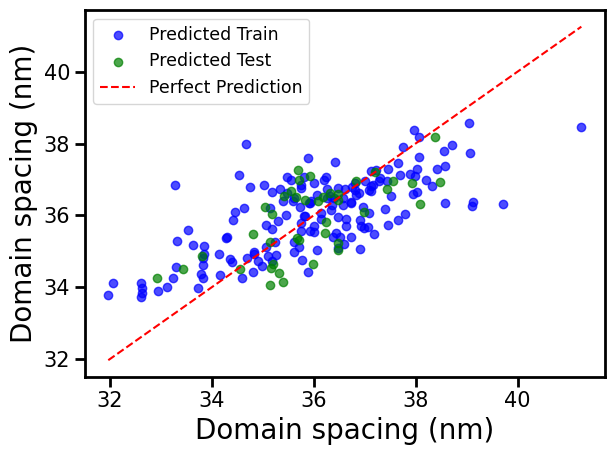

In [11]:
# Define the figure title
fig_title = f'{model_output}_avp.png'

# set formatting for plots
%matplotlib inline
# from matplotlib import cm
from matplotlib import rc
rc('text', usetex=False)
rc('mathtext', fontset='cm')
rc('xtick', labelsize=15)  
rc('xtick.major', size=7)   
rc('xtick.minor', size=4)
rc('xtick.major', width=2)
rc('xtick.minor', width=2)
rc('ytick.major', width=2)
rc('ytick.minor', width=2)
rc('ytick', labelsize=15)
rc('ytick.major', size=7)
rc('ytick.minor', size=4)
rc('axes', labelsize=15) 
rc('axes', linewidth=2) 
rc('font',family='sans serif')
rc('font', style='normal')
rc('font', weight='500')
rc('font', size='15')
rc('axes', labelweight='500')
rc('axes.spines', **{'right':True, 'top':True})   

# Create a scatter plot
plt.scatter(y_train, mlp_train, color='blue', label='Predicted Train', alpha=0.7)
plt.scatter(y_test, mlp_test, color='green', label='Predicted Test', alpha=0.7)

# Add a diagonal line for reference (perfect prediction)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linestyle='--', color='red', label='Perfect Prediction')

# Add labels and a legend
plt.xlabel('Domain spacing (nm)', fontsize='20')
plt.ylabel('Domain spacing (nm)', fontsize='20')

# Set legend background color to white
legend = plt.legend(fontsize='12.5')
legend.get_frame().set_facecolor('white')

# Set the background color to white
plt.gca().set_facecolor('white')

# Remove gridlines
plt.grid(False)

# Add tickmarks to x and y axes
plt.tick_params(axis='both', which='both', reset=True, top=False, right=False)

# # Add black borders to the grid
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')

# Show the plot
plt.tight_layout()
# plt.savefig(output_path + fig_title, format='png')
plt.show()

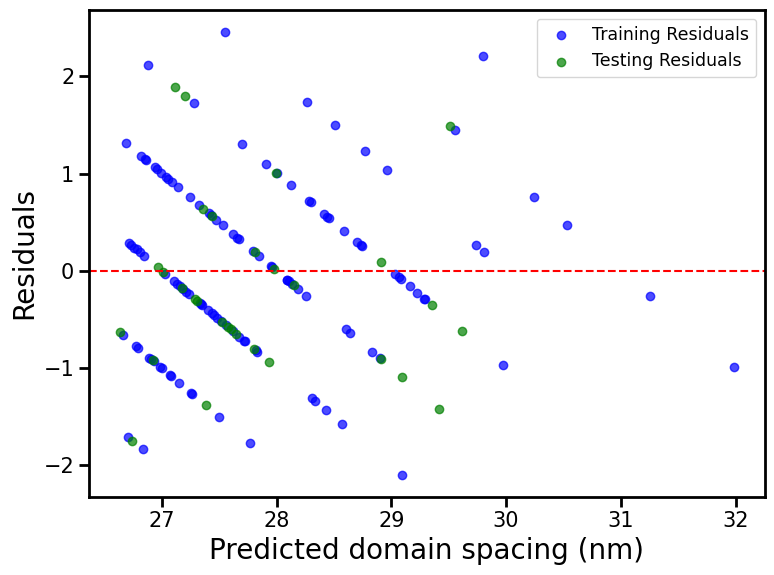

In [9]:
# Define the figure title
fig_title = f'{model_output}_residuals.png'

res_train = y_train - mpltrain
res_test = y_test - mpleval

# set formatting for plots
%matplotlib inline
rc('text', usetex=False)
rc('mathtext', fontset='cm')
rc('xtick', labelsize=15)  
rc('xtick.major', size=7)   
rc('xtick.minor', size=4)
rc('xtick.major', width=2)
rc('xtick.minor', width=2)
rc('ytick.major', width=2)
rc('ytick.minor', width=2)
rc('ytick', labelsize=15)
rc('ytick.major', size=7)
rc('ytick.minor', size=4)
rc('axes', labelsize=15) 
rc('axes', linewidth=2) 
rc('font',family='sans serif')
rc('font', style='normal')
rc('font', weight='500')
rc('font', size='15')
rc('axes', labelweight='500')
rc('axes.spines', **{'right':True, 'top':True})   

# Create a residuals plot
plt.figure(figsize=(8, 6))
plt.scatter(mpltrain, res_train, color='blue', alpha=0.7, label='Training Residuals')
plt.scatter(mpleval, res_test, color='green', alpha=0.7, label='Testing Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel("Predicted domain spacing (nm)", fontsize='20')
plt.ylabel("Residuals", fontsize='20')
# Set legend background color to white
legend = plt.legend(fontsize='12.5')
legend.get_frame().set_facecolor('white')

# Set the background color to white
plt.gca().set_facecolor('white')

# Remove gridlines
plt.grid(False)

# Add tickmarks to x and y axes
plt.tick_params(axis='both', which='both', reset=True, top=False, right=False)

# # Add black borders to the grid
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')

plt.grid(False)
plt.tight_layout()
plt.savefig(output_path + fig_title, format='png')
plt.show()

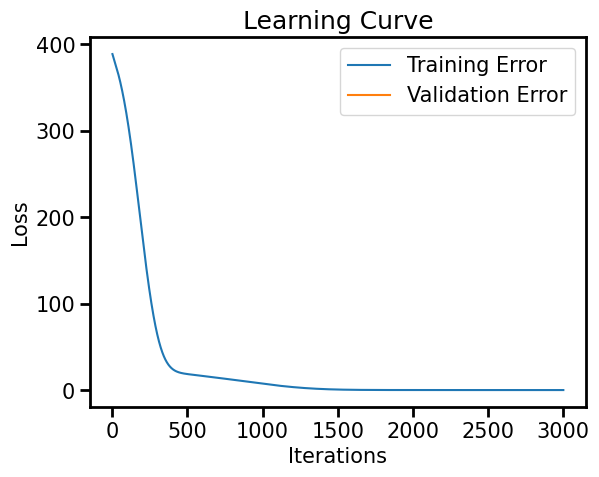

In [10]:
train_errors = []
val_errors = []

for i in range(mlp_regressor.max_iter):
    mlp_regressor.partial_fit(X_train, y_train)
    train_error = mlp_regressor.loss_
    train_errors.append(train_error)
    val_errors.append(mlp_regressor.validation_scores_)

    # Check for early stopping
    if mlp_regressor.early_stopping and (i > 0) and (val_errors[-1] > val_errors[-2]):
        break

# Plot the learning curve
plt.plot(np.arange(1, len(train_errors) + 1), train_errors, label='Training Error')
plt.plot(np.arange(1, len(val_errors) + 1), val_errors, label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [11]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from graphviz import Digraph

# Create synthetic data for demonstration
X_train, y_train = make_regression(n_samples=100, n_features=10, noise=0.1)

# Create and train MLPRegressor model
mlp_regressor = MLPRegressor(hidden_layer_sizes=(50, 50), activation='relu', solver='adam', alpha=0.0001, learning_rate='constant', max_iter=3000, tol=1e-4)
mlp_regressor.fit(X_train, y_train)

# Create graph
dot = Digraph()

# Add input layer
dot.node('Input', shape='ellipse')

# Add hidden layers
for i, n_neurons in enumerate(mlp_regressor.hidden_layer_sizes):
    for j in range(n_neurons):
        dot.node(f'Hidden_{i}_{j}', shape='circle')

# Add output layer
dot.node('Output', shape='ellipse')

# Connect input layer to the first hidden layer
for i in range(mlp_regressor.hidden_layer_sizes[0]):
    dot.edge('Input', f'Hidden_0_{i}')

# Connect hidden layers
for i in range(len(mlp_regressor.hidden_layer_sizes) - 1):
    for j in range(mlp_regressor.hidden_layer_sizes[i]):
        for k in range(mlp_regressor.hidden_layer_sizes[i+1]):
            dot.edge(f'Hidden_{i}_{j}', f'Hidden_{i+1}_{k}')

# Connect last hidden layer to output layer
for i in range(mlp_regressor.hidden_layer_sizes[-1]):
    dot.edge(f'Hidden_{len(mlp_regressor.hidden_layer_sizes)-1}_{i}', 'Output')

# Render the graph
dot.render('neural_network', format='png', cleanup=True)

/home/bradley/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


'neural_network.png'

In [12]:
from joblib import dump, load

dump(best, 'nn_domain_afm.joblib')

['nn_domain_afm.joblib']